Step 0: Setup Google Drive Environment

In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [ ]:
# Importing libraries
from pandas import read_csv
from statsmodels.tsa.stattools import adfuller
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 

from pylab import rcParams

import statsmodels.api as sm
from numpy.random import normal, seed
from scipy.stats import norm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
import math
from sklearn.metrics import mean_squared_error

from plotly import tools

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff

In [5]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [6]:
from tabulate import tabulate

link = 'https://drive.google.com/open?id=1xZ648Np5GN3ICHv1j9Sww8pyY6OoGlYK'


fluff, id = link.split('=')
file = drive.CreateFile({'id':id}) 
file.GetContentFile('MSFT_Stock.csv') 
microsoft = pd.read_csv('MSFT_Stock.csv', index_col='Date', parse_dates=['Date'])
TS_Monthly_df = pd.read_csv('MSFT_Stock.csv')
microsoft.head()

,Open,High,Low,Close,Volume
Date,,,,,
2015-04-01 16:00:00,40.60,40.76,40.31,40.72,36865322
2015-04-02 16:00:00,40.66,40.74,40.12,40.29,37487476
2015-04-06 16:00:00,40.34,41.78,40.18,41.55,39223692
2015-04-07 16:00:00,41.61,41.91,41.31,41.53,28809375
2015-04-08 16:00:00,41.48,41.69,41.04,41.42,24753438


In [7]:
import matplotlib.pyplot as plt
TS_df = microsoft

#Step 1: Data Exploration

#1.1 Investigate Raw Dataset

In [8]:
TS_df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2015-04-01 16:00:00,40.60,40.76,40.31,40.72,36865322
2015-04-02 16:00:00,40.66,40.74,40.12,40.29,37487476
2015-04-06 16:00:00,40.34,41.78,40.18,41.55,39223692
2015-04-07 16:00:00,41.61,41.91,41.31,41.53,28809375
2015-04-08 16:00:00,41.48,41.69,41.04,41.42,24753438


In [9]:
TS_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1511 entries, 2015-04-01 16:00:00 to 2021-03-31 16:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1511 non-null   float64
 1   High    1511 non-null   float64
 2   Low     1511 non-null   float64
 3   Close   1511 non-null   float64
 4   Volume  1511 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 70.8 KB


In [10]:
TS_df.nunique()

Open      1409
High      1400
Low       1397
Close     1398
Volume    1511
dtype: int64

In [11]:
TS_df.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

# EDA

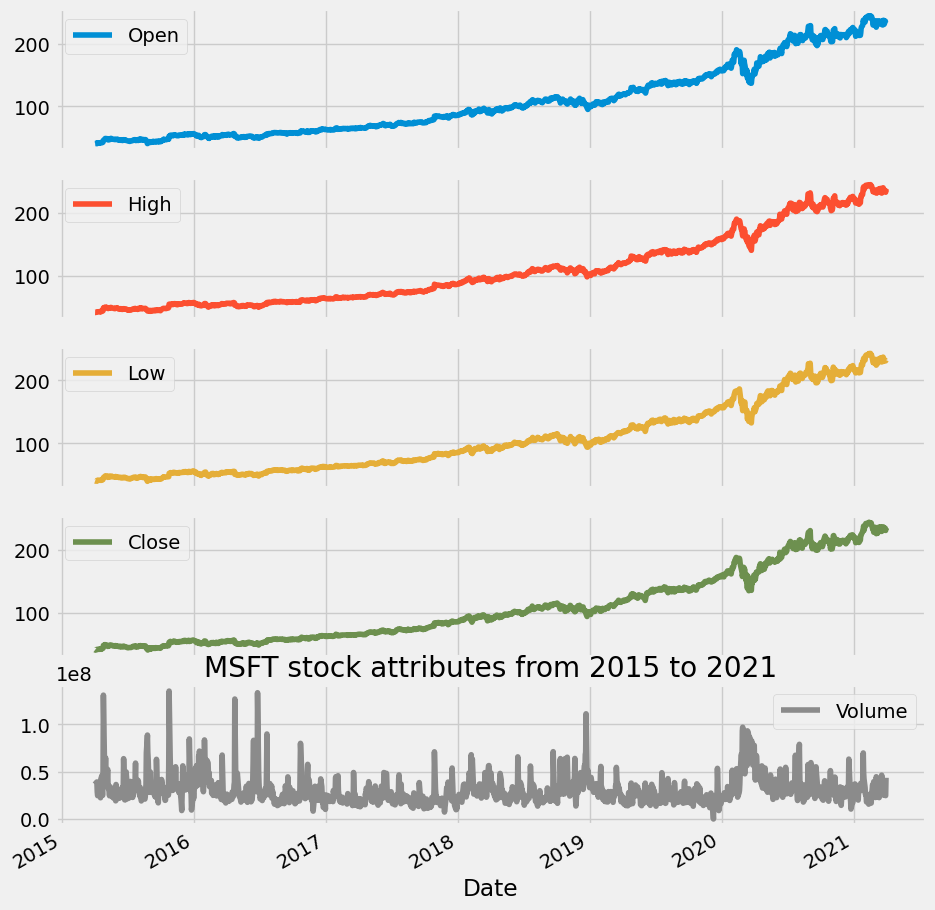

In [12]:
TS_df['2015':'2021'].plot(subplots=True, figsize=(10,12))
plt.title('MSFT stock attributes from 2015 to 2021')
plt.savefig('stocks.png')

<Axes: xlabel='Date'>

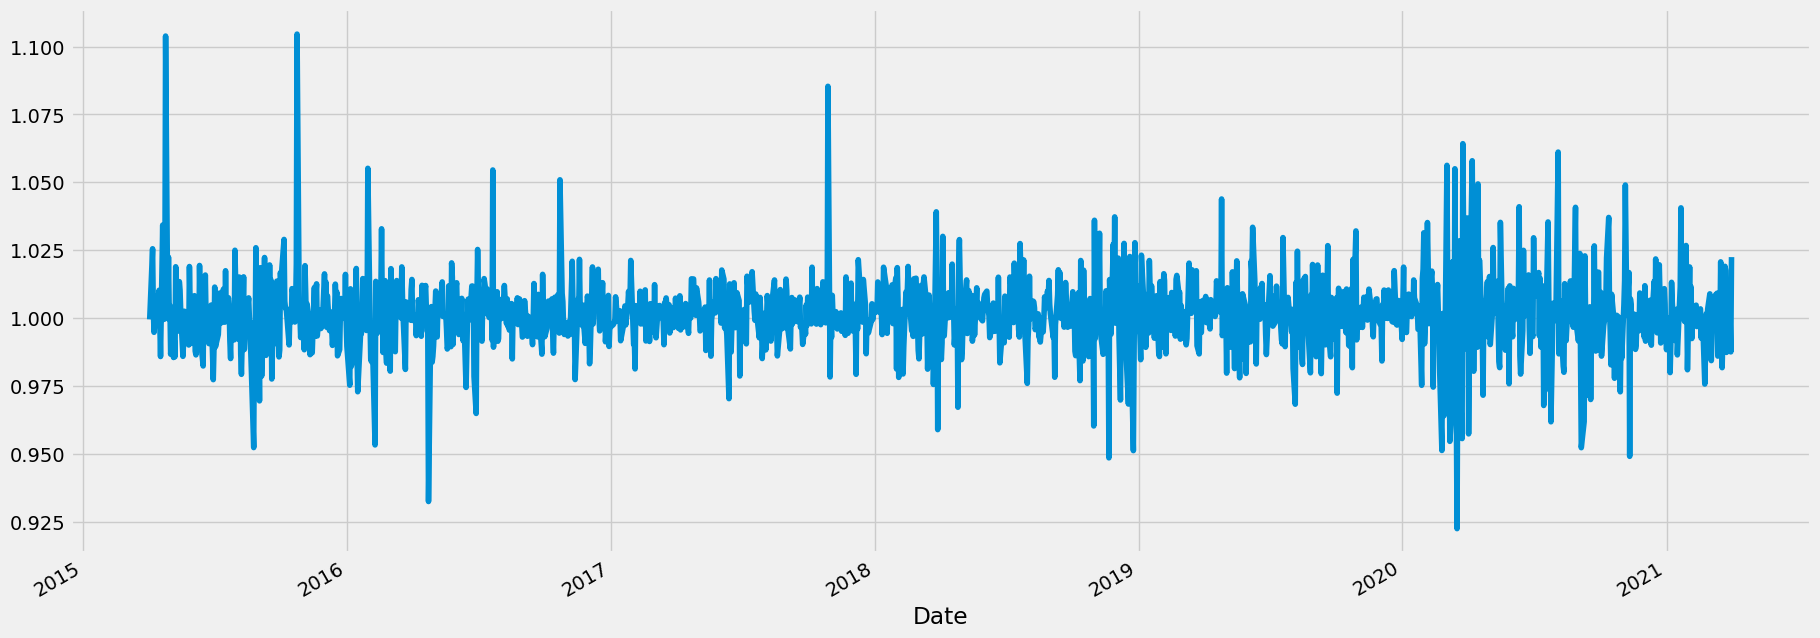

In [13]:
TS_df['Change'] = TS_df.High.div(TS_df.High.shift())
TS_df['Change'].plot(figsize=(20,8))

<Axes: xlabel='Date'>

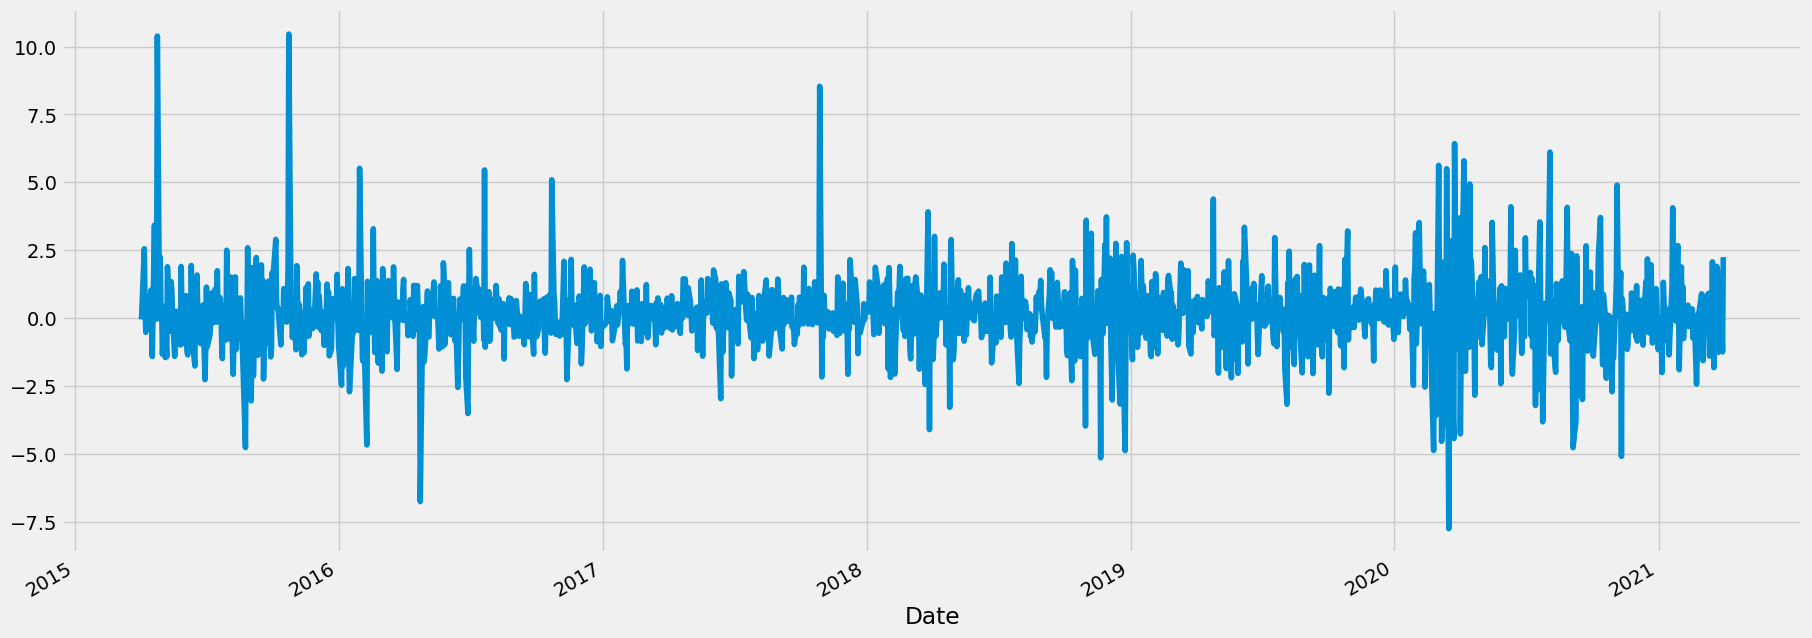

In [14]:
TS_df['Return'] = TS_df.Change.sub(1).mul(100)
TS_df['Return'].plot(figsize=(20,8))

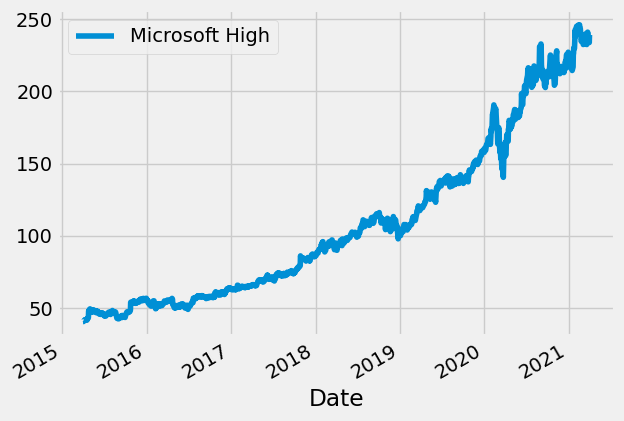

In [15]:
TS_df.High.plot()
plt.legend(['Microsoft High'])

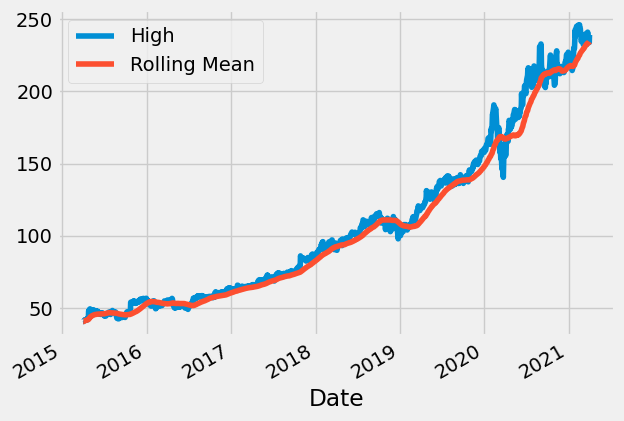

In [17]:
rolling_MSFT = TS_df.High.rolling('90D').mean()
TS_df.High.plot()
rolling_MSFT.plot()
plt.legend(['High','Rolling Mean'])

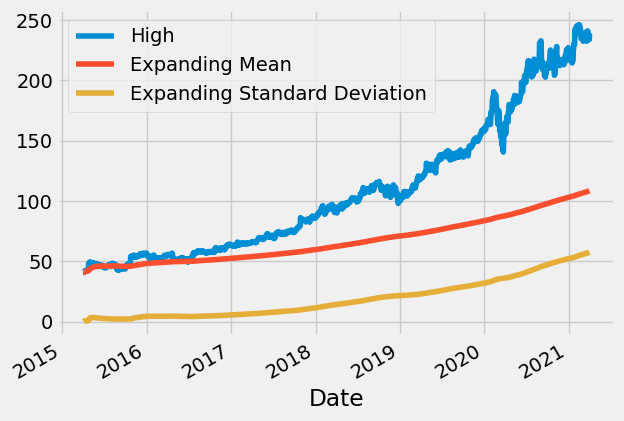

In [18]:
microsoft_mean = TS_df.High.expanding().mean()
microsoft_std = TS_df.High.expanding().std()
TS_df.High.plot()
microsoft_mean.plot()
microsoft_std.plot()
plt.legend(['High','Expanding Mean','Expanding Standard Deviation'])

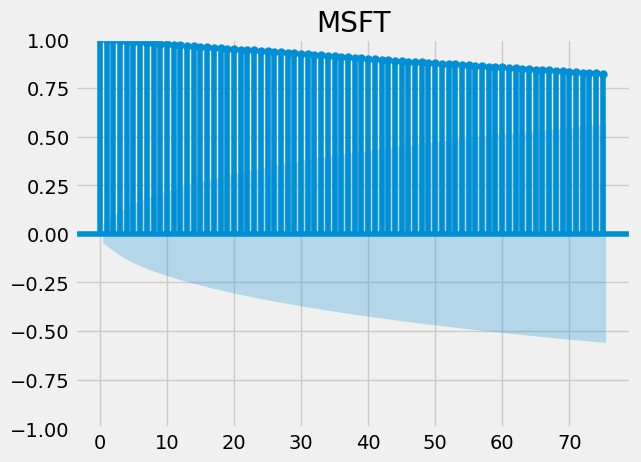

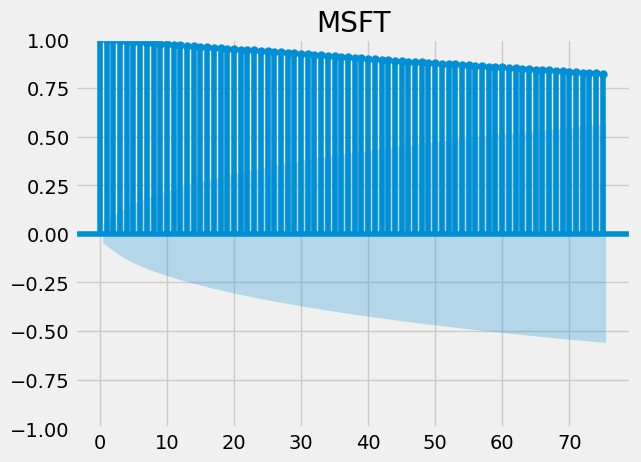

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(TS_df["High"],lags=75,title="MSFT")

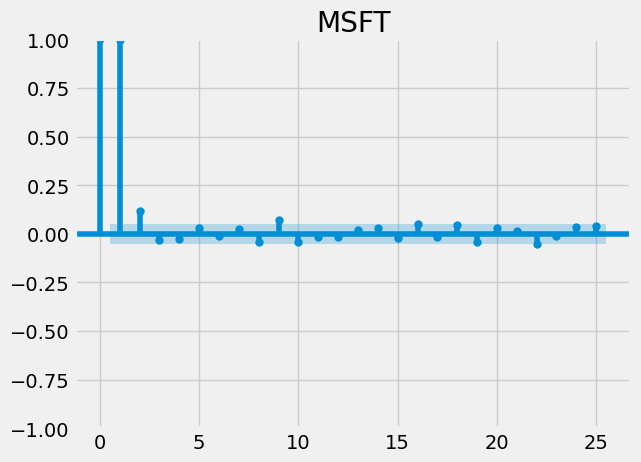

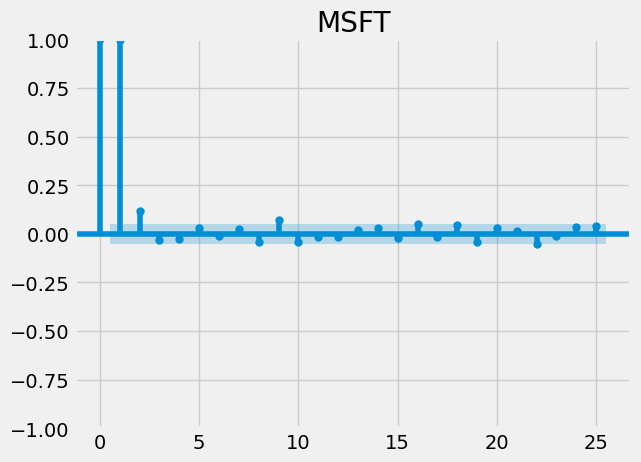

In [21]:
plot_pacf(TS_df["Close"],lags=25,title="MSFT")

In [22]:
TS_Monthly_df['dateN']=pd.to_datetime(TS_Monthly_df['Date'])

TS_Monthly_df.set_index('dateN',inplace=True)

TS_Monthly_df.head()

,Date,Open,High,Low,Close,Volume
dateN,,,,,,
2015-04-01 16:00:00,4/1/2015 16:00:00,40.60,40.76,40.31,40.72,36865322
2015-04-02 16:00:00,4/2/2015 16:00:00,40.66,40.74,40.12,40.29,37487476
2015-04-06 16:00:00,4/6/2015 16:00:00,40.34,41.78,40.18,41.55,39223692
2015-04-07 16:00:00,4/7/2015 16:00:00,41.61,41.91,41.31,41.53,28809375
2015-04-08 16:00:00,4/8/2015 16:00:00,41.48,41.69,41.04,41.42,24753438


<Axes: xlabel='dateN'>

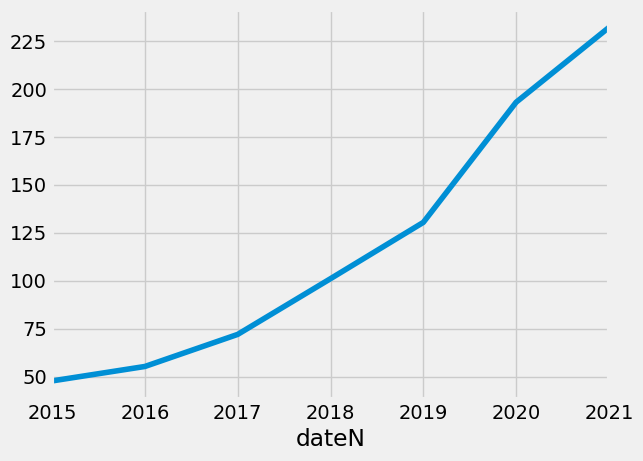

In [23]:
TS_Monthly_df['Close'].resample('Y').mean().plot()

In [24]:
TS_Monthly_df.describe()

,Open,High,Low,Close,Volume
count,1511.000000,1511.000000,1511.000000,1511.000000,1.511000e+03
mean,107.385976,108.437472,106.294533,107.422091,3.019863e+07
std,56.691333,57.382276,55.977155,56.702299,1.425266e+07
min,40.340000,40.740000,39.720000,40.290000,1.016120e+05
25%,57.860000,58.060000,57.420000,57.855000,2.136213e+07
50%,93.990000,95.100000,92.920000,93.860000,2.662962e+07
75%,139.440000,140.325000,137.825000,138.965000,3.431962e+07
max,245.030000,246.130000,242.920000,244.990000,1.352271e+08


# Step 2: Data cleaning and feature analysis

# Data Description

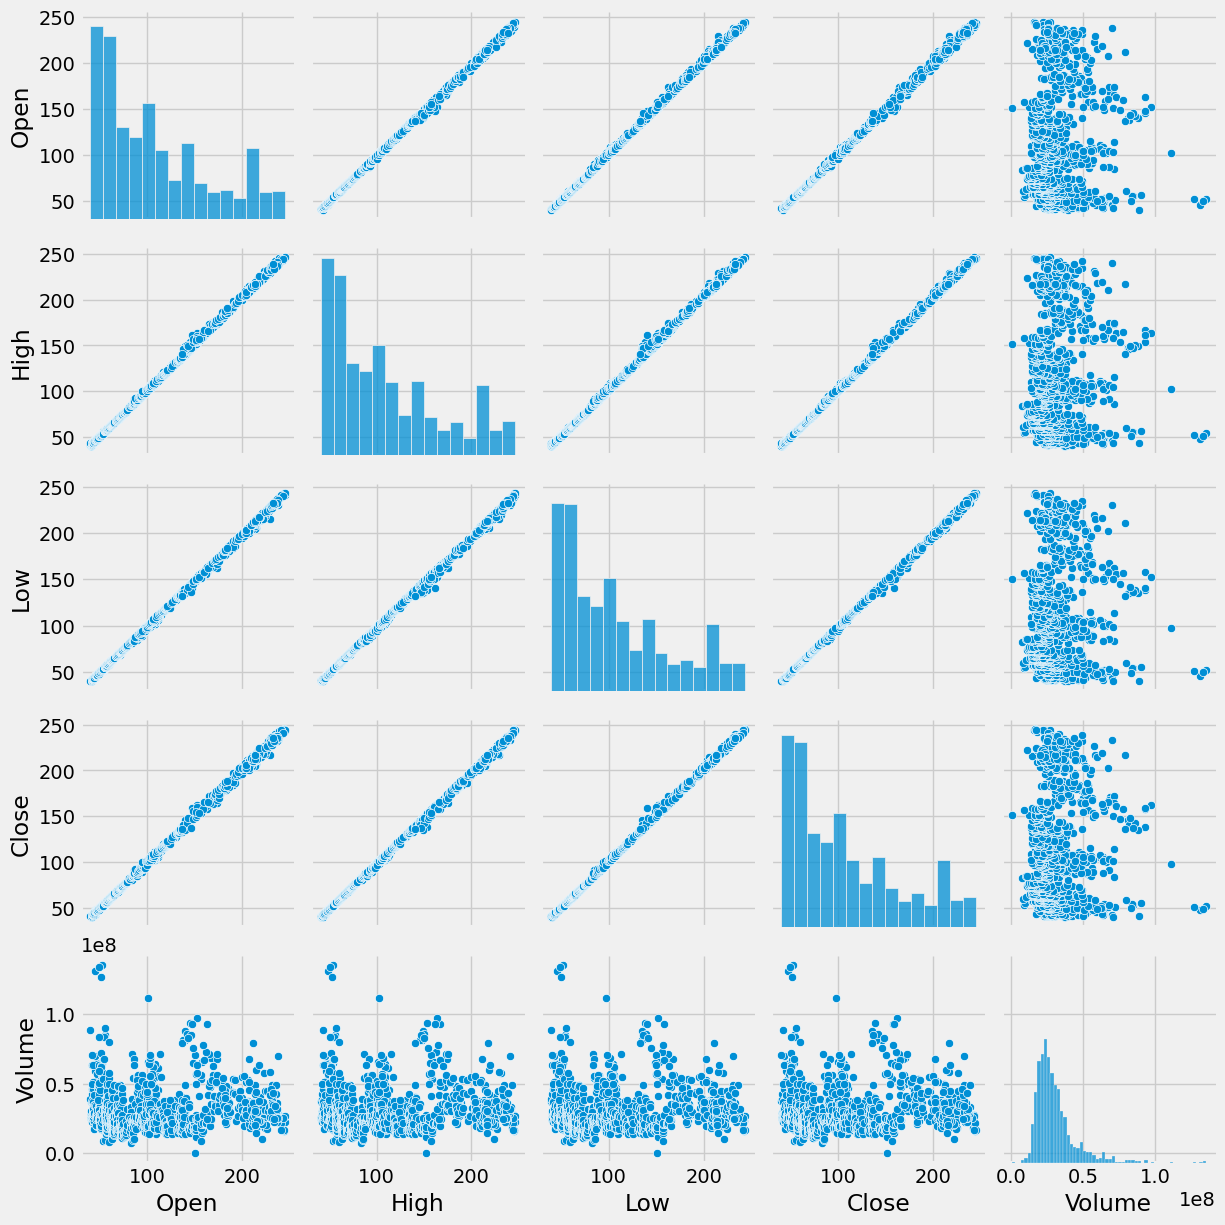

In [25]:
import seaborn as sns
sns.pairplot(data=TS_Monthly_df)

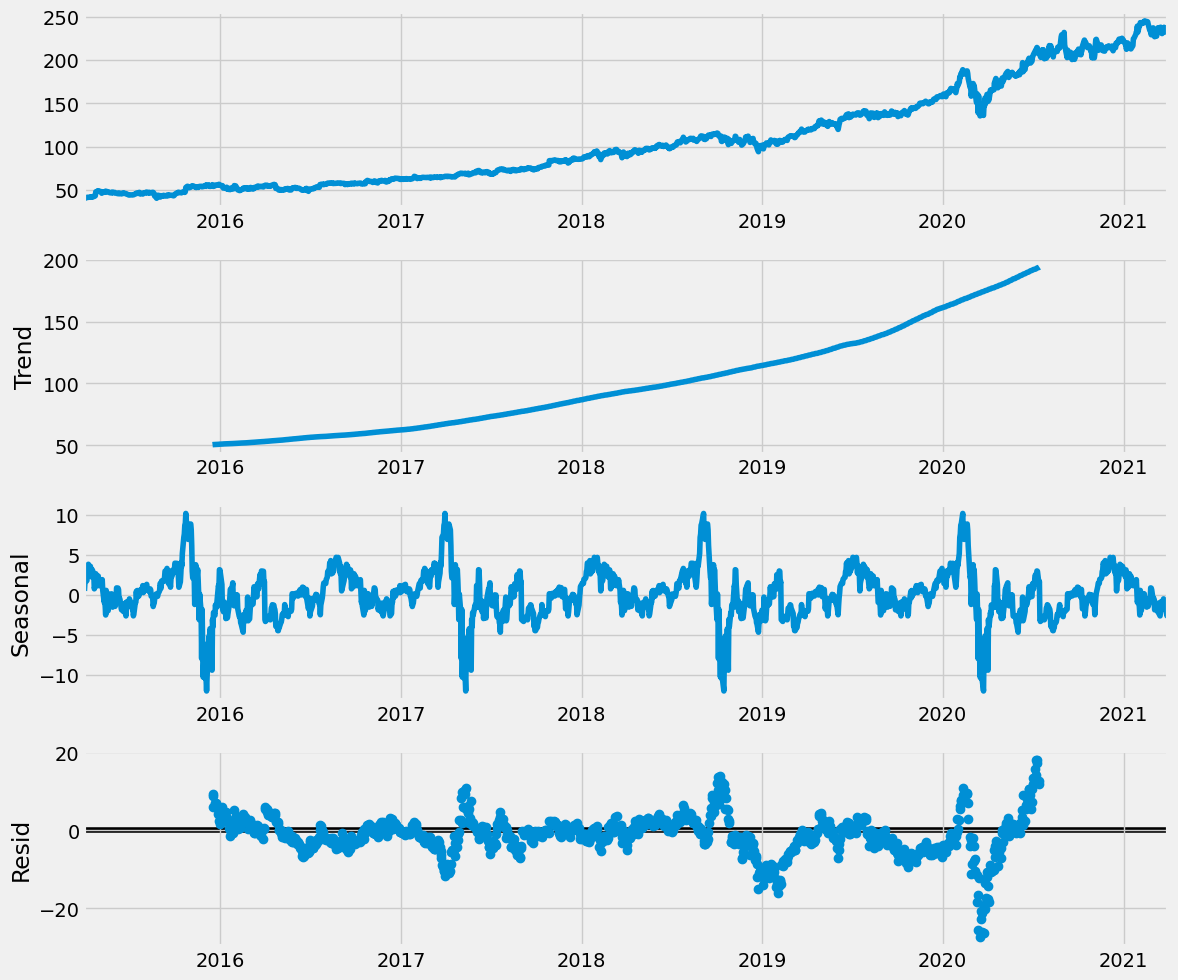

In [26]:
rcParams['figure.figsize'] = 12, 10
pred_df_sim1_new = sm.tsa.seasonal_decompose(TS_Monthly_df[['Close']],model='additive',period=360) # The frequncy is annual

pred_df_sim2_full = TS_Monthly_df[['Close']]
figure = pred_df_sim1_new.plot()
plt.show()

In [27]:
sim1 = pred_df_sim1_new.resid.dropna()
sim2 = pred_df_sim2_full.dropna()

# Step 3: Make Model

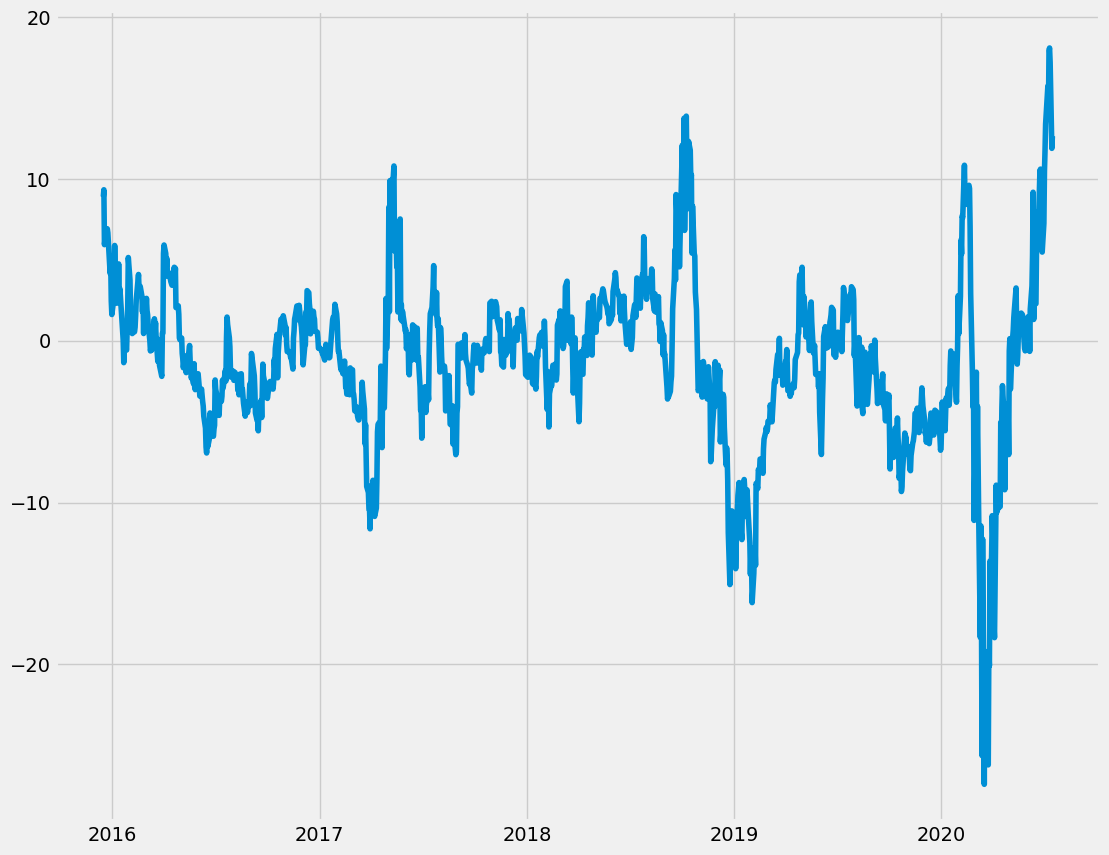

In [28]:
plt.plot(sim1)

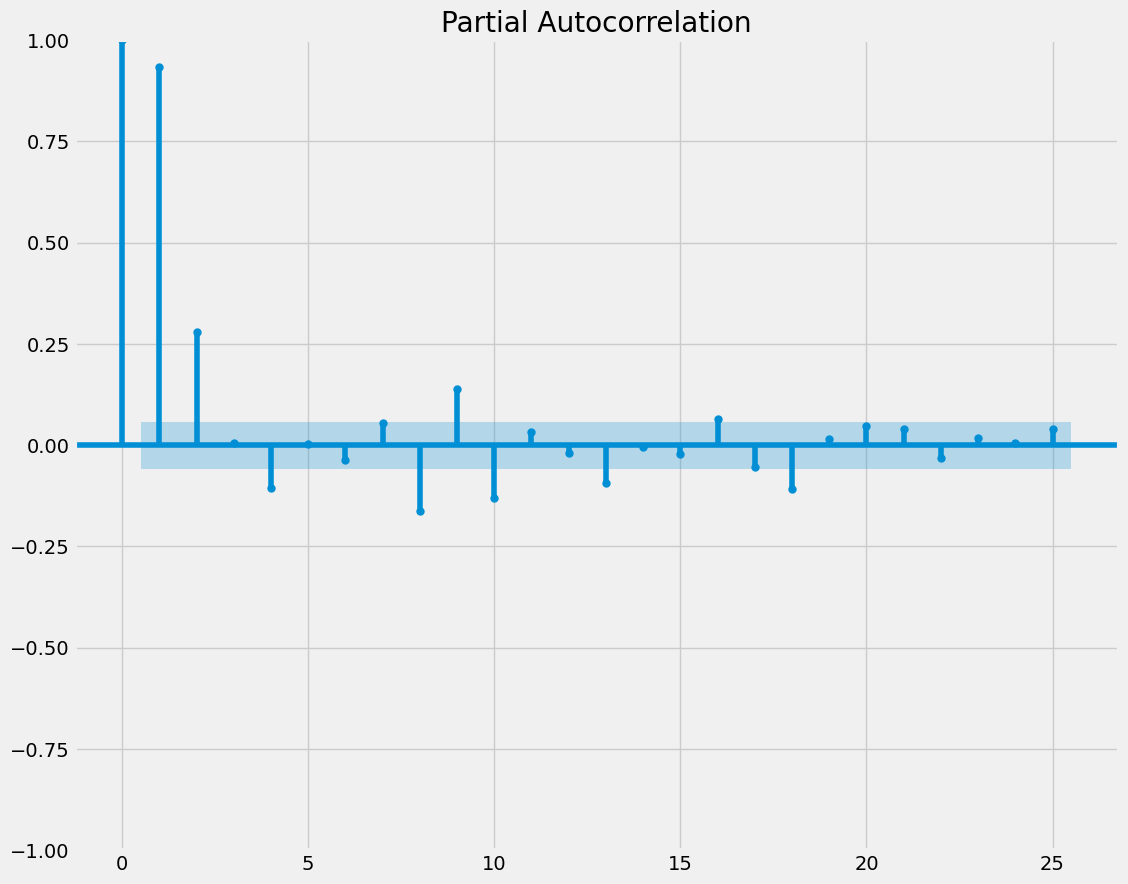

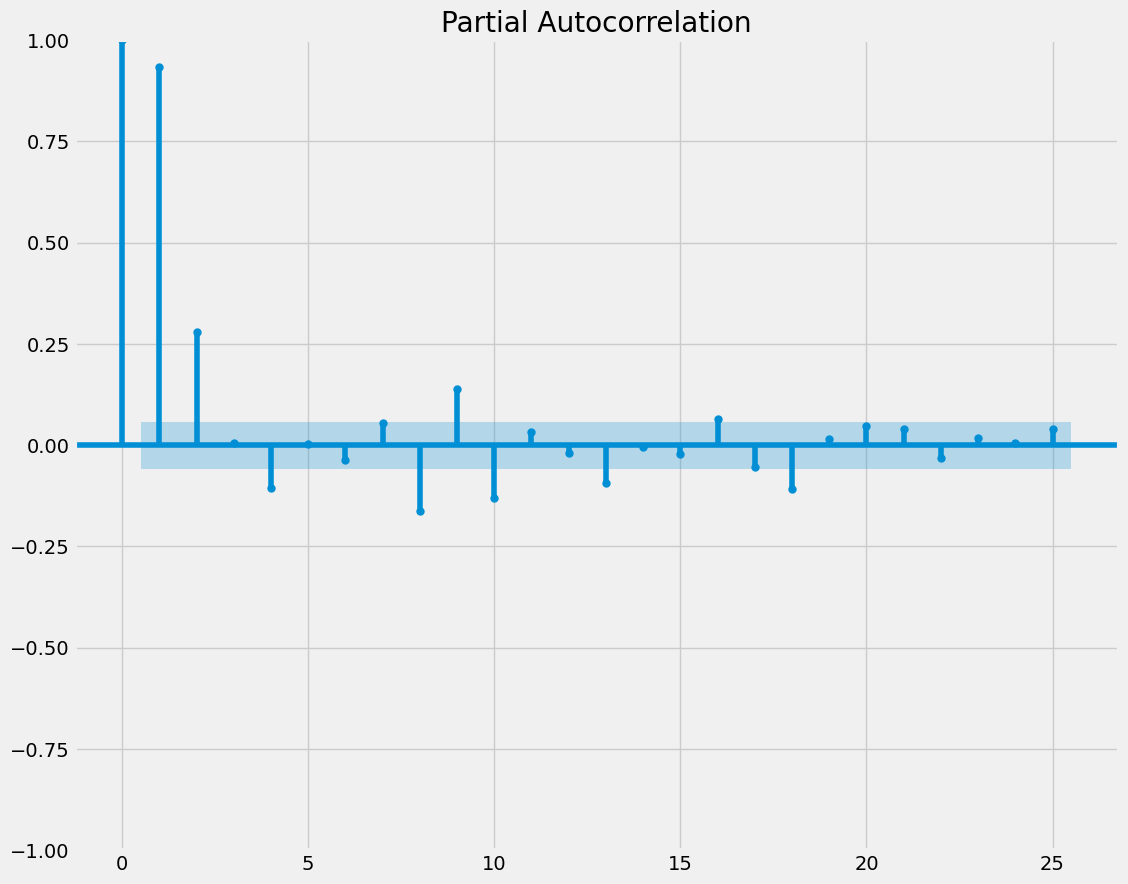

In [29]:
plot_pacf(sim1, lags=25)

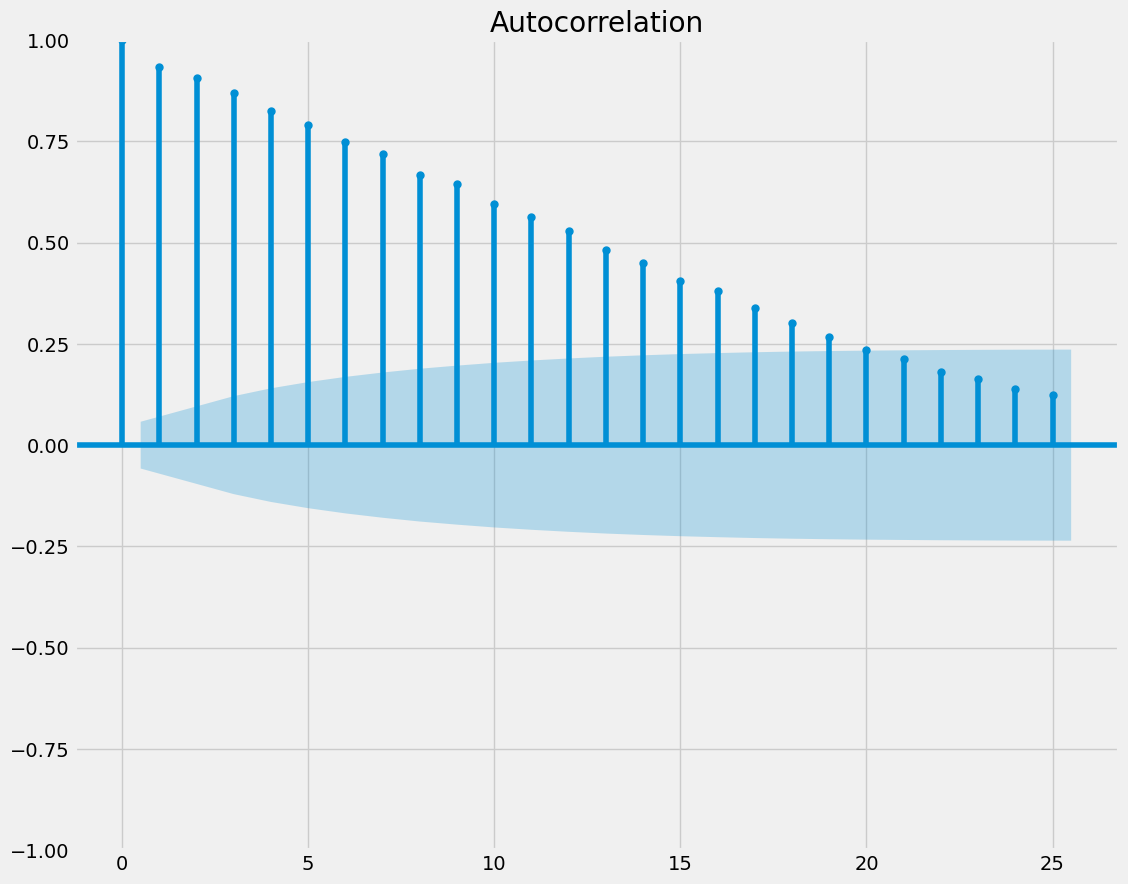

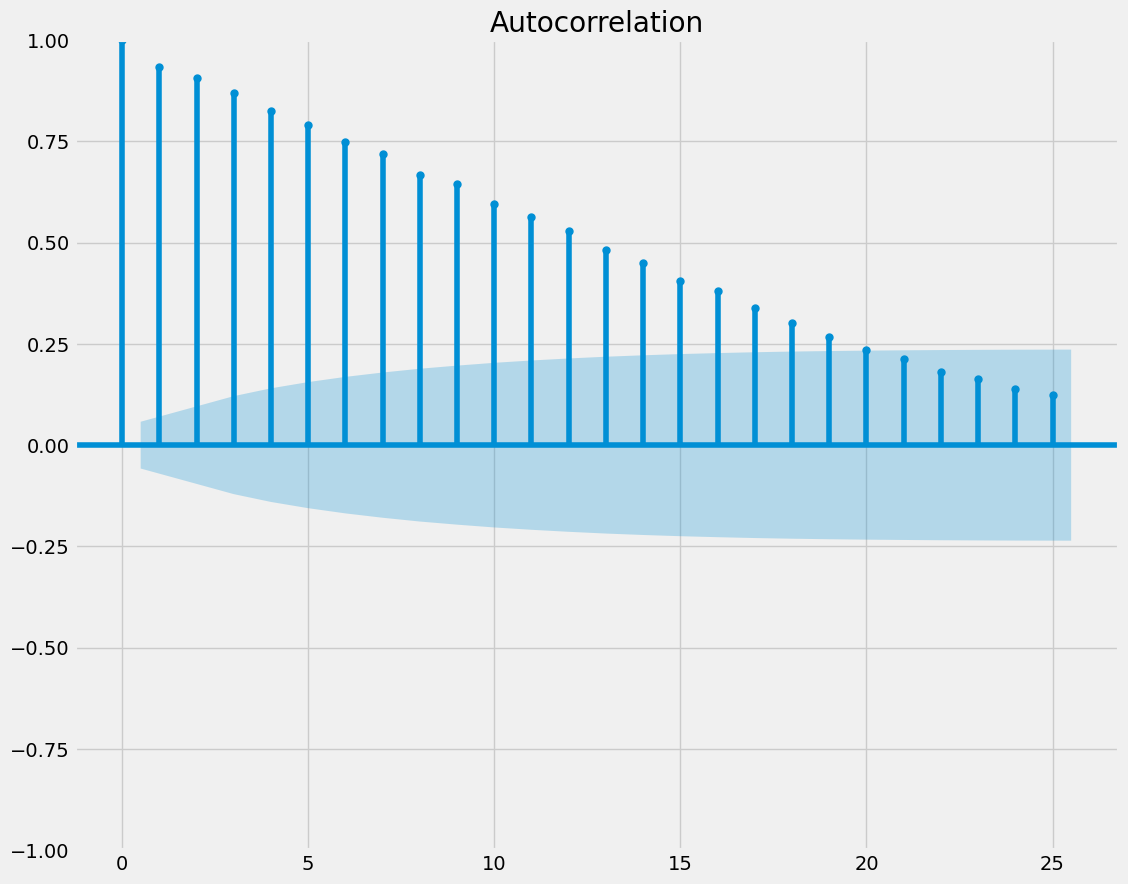

In [30]:
plot_acf(sim1, lags=25)

In [31]:
import statsmodels.tsa.arima.model as ArimaModel
#statsmodels.tsa.arima.model.ARIMA

model = ArimaModel.ARIMA(sim1, order=(2,1,0))
result = model.fit()

In [32]:
result.predict(start=1000, end=1200)
plt.show()

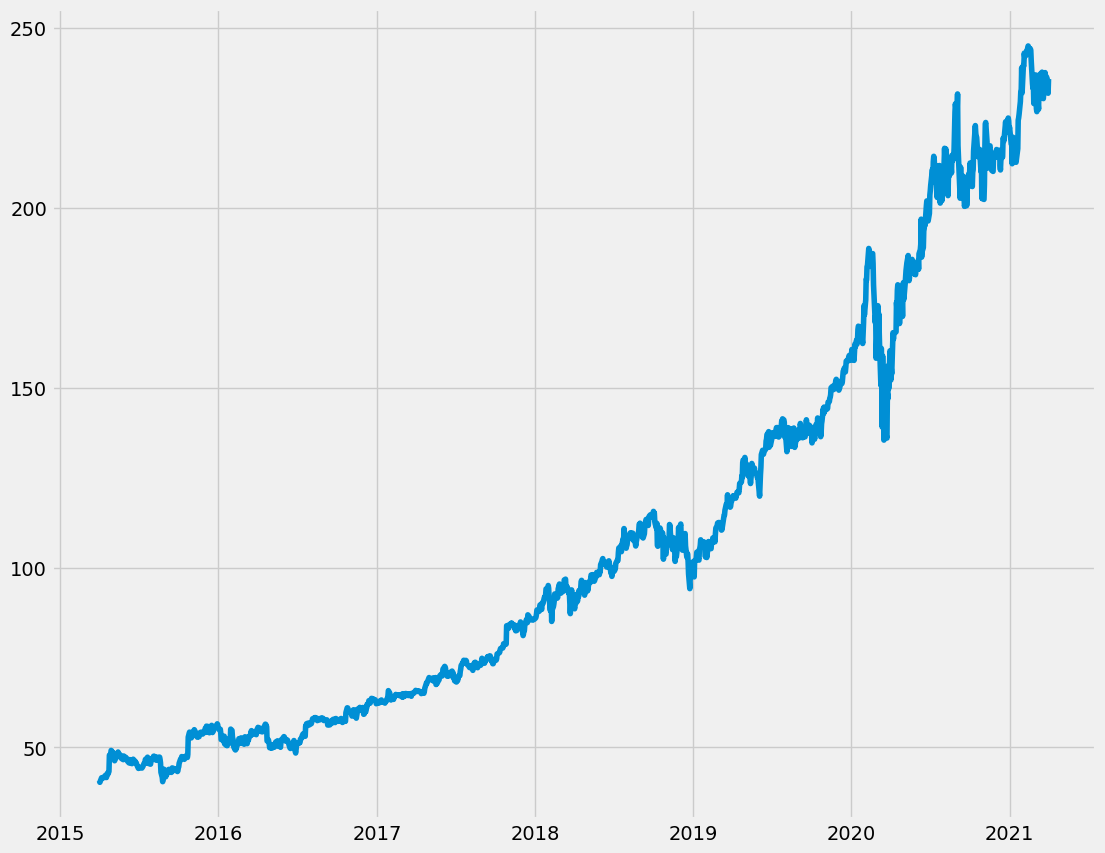

In [33]:
plt.plot(sim2)

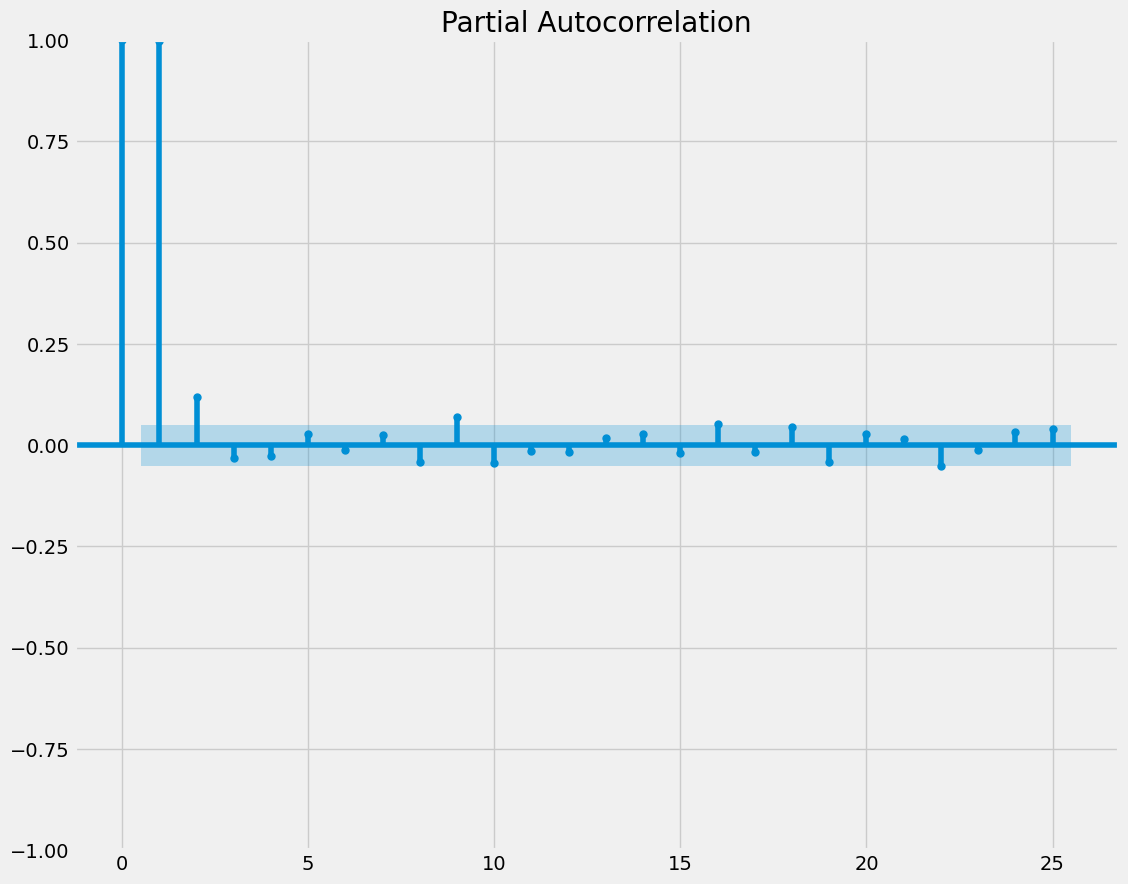

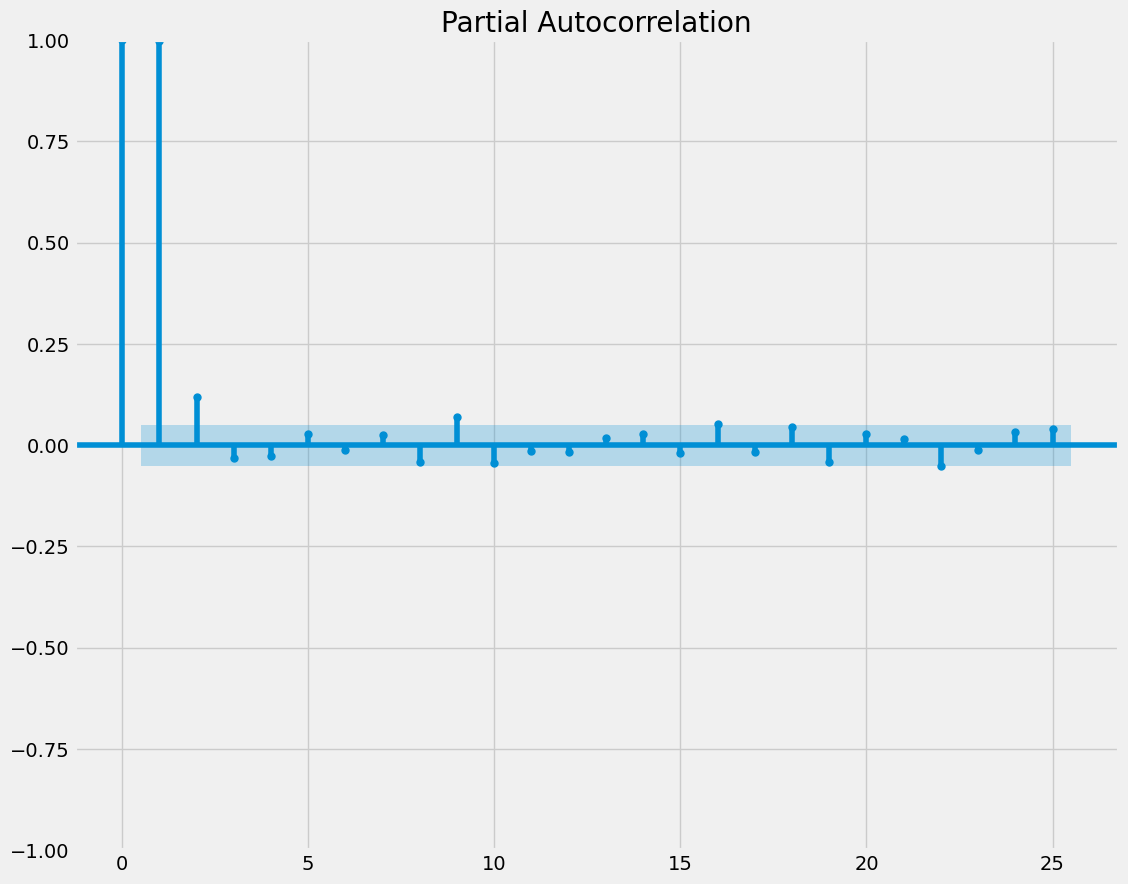

In [34]:
plot_pacf(sim2, lags=25)

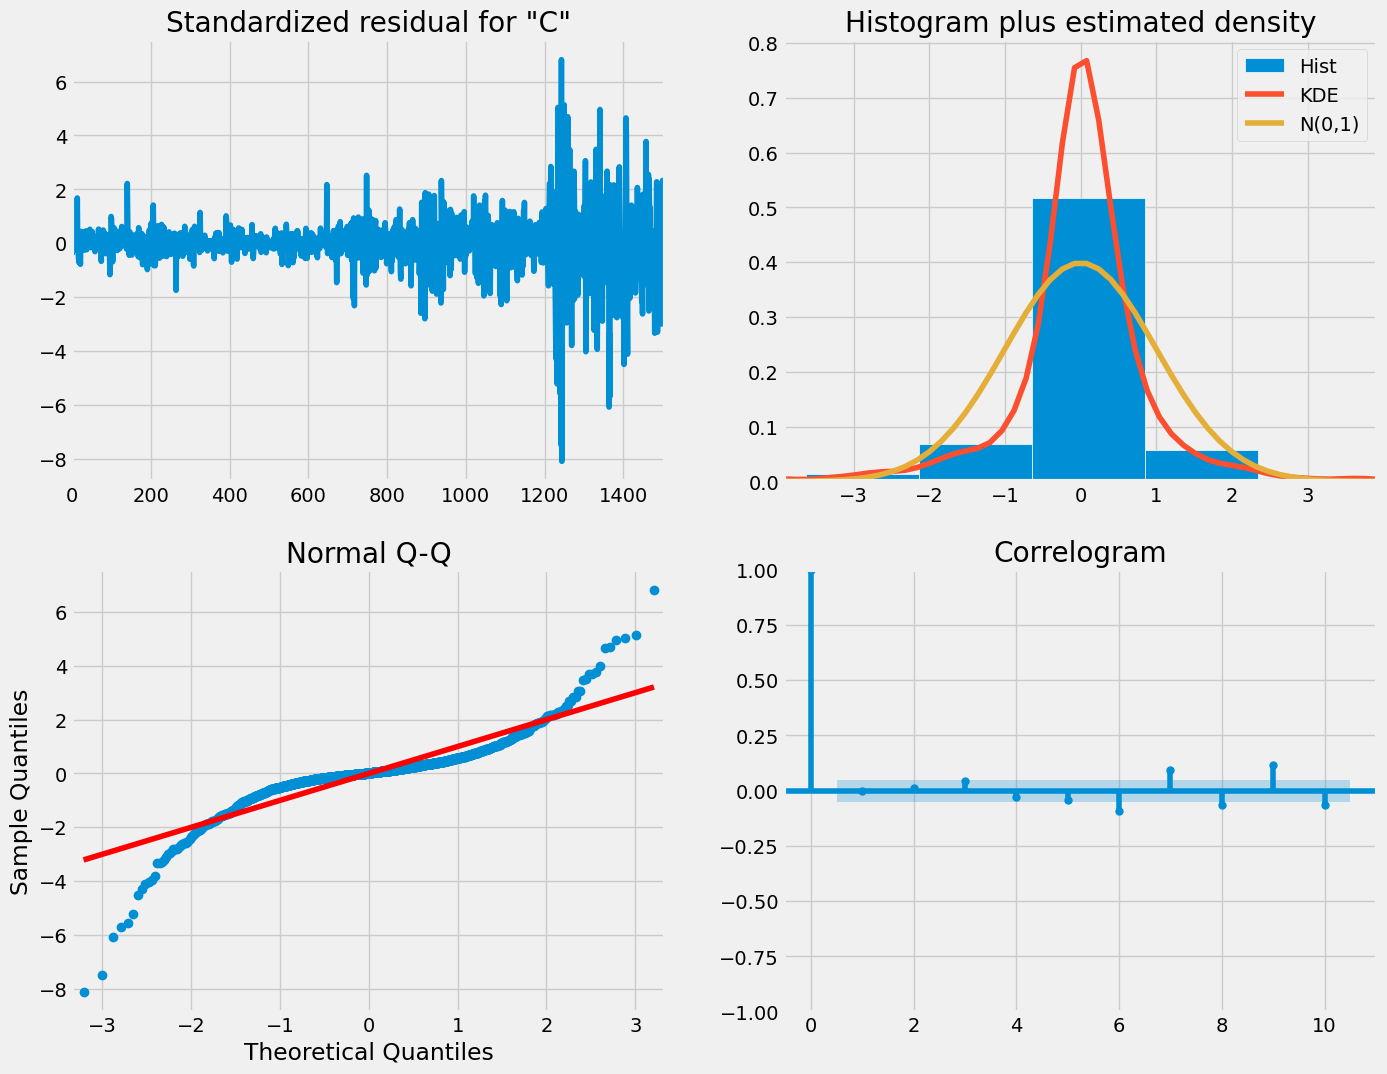

In [36]:
mod = sm.tsa.statespace.SARIMAX(sim2,
                                order=(2, 3, 2), 
				)

MSFTresults = mod.fit()

MSFTresults.plot_diagnostics(figsize=(15, 12))
plt.show()

In [37]:
pred = MSFTresults.get_prediction(start=1400, dynamic=False)

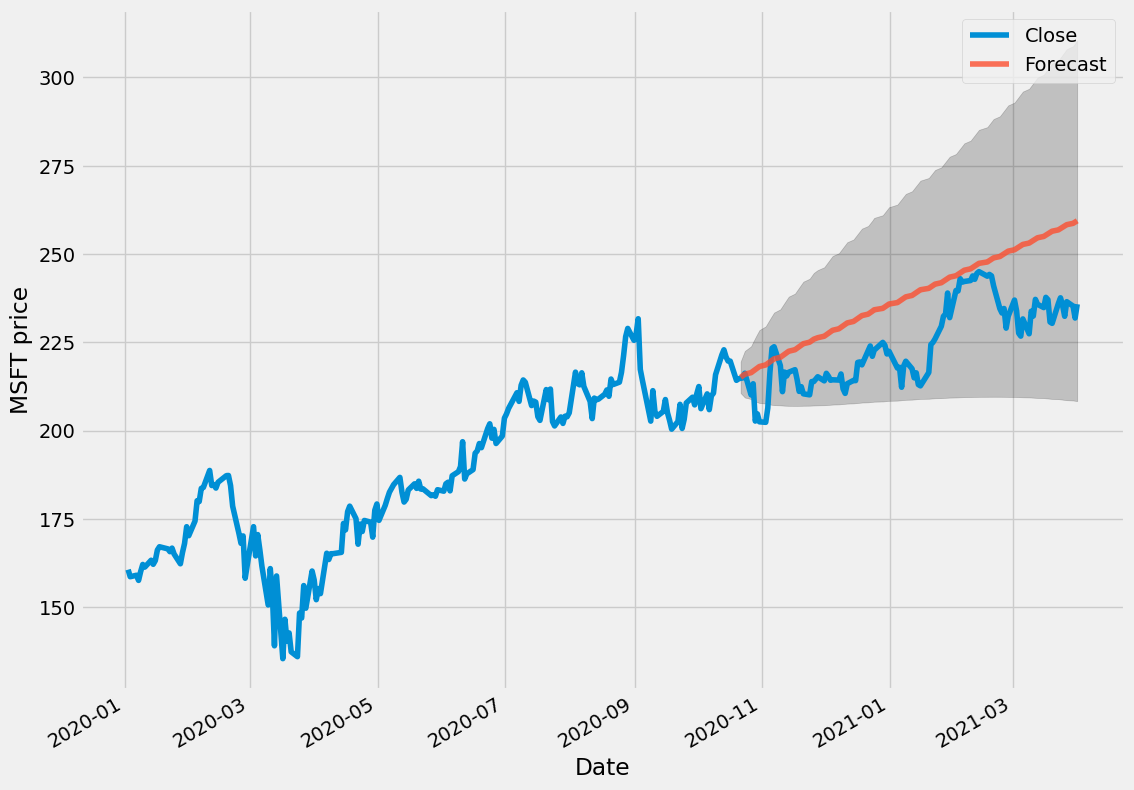

In [46]:
pred_ci = pred.conf_int()
#Returns the confidence interval of the fitted parameters. 

ax = sim2['2020':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.8)

ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('MSFT price')
plt.legend()

plt.show()

In [39]:
pred = MSFTresults.get_prediction(start=1400, dynamic=True)

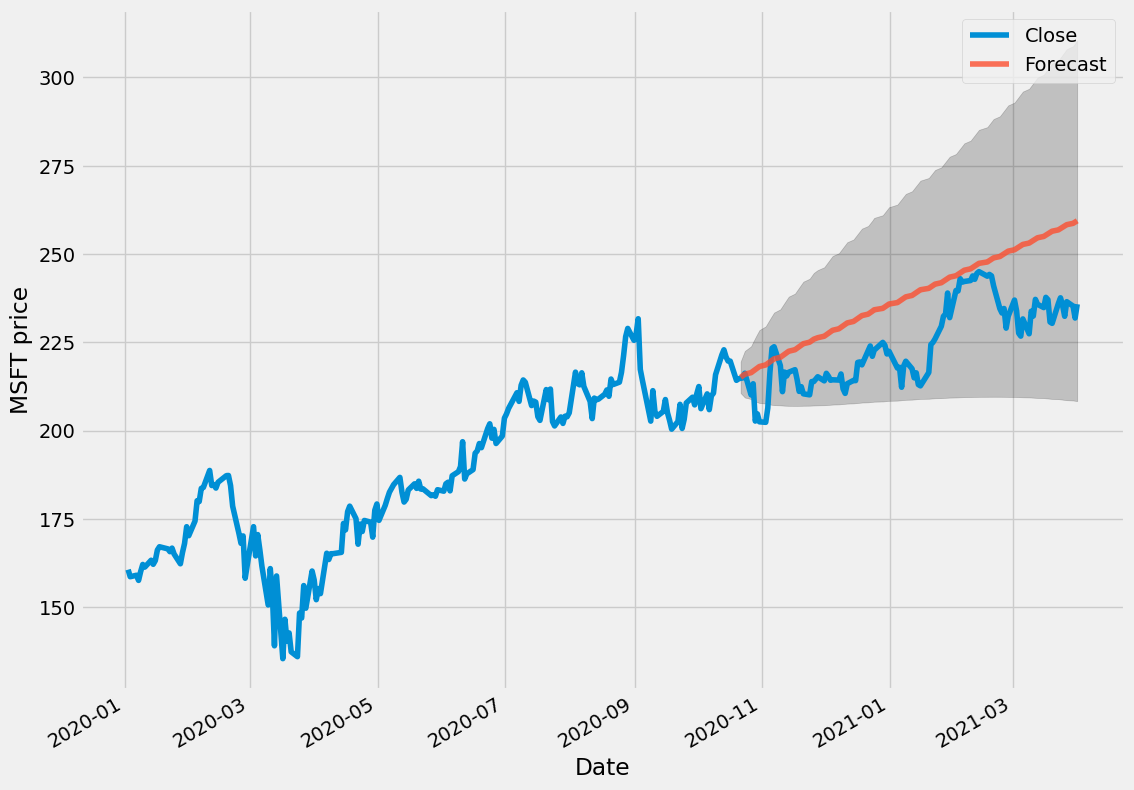

In [42]:
pred_ci = pred.conf_int()
#Returns the confidence interval of the fitted parameters. 

ax = sim2['2020':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.8)

ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('MSFT price')
plt.legend()

plt.show()